# making avg day

## follow along at:

slides:
### [thisisreal.net/talks/20181009_boulder_python/](https://thisisreal.net/talks/20181009_boulder_python/)
notebook:
### [https://github.com/whlteXbread/talk_notebooks/](https://github.com/whlteXbread/talk_notebooks/blob/master/20181009_boulder_python_avg_day.ipynb)

andrew catellier

thisisreal.net

@whltexbread

@whltexbread@xoxo.zone

github.com/whltexbread

for work
* geovisual analytics
  * computer vision/machine learning scientist
* us doc—institute for telecommunication science
  * "expert"—audio and video quality estimation

for fun:
* [photos](https://thisisreal.net/imglib)
* [blog](https://negativesign.com)
* other stuff

In [1]:
from pathlib import Path

import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skimage import exposure, io

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,9)

In [3]:
DEMO_IMAGE_SIZE = (7, 7)

SMILE_MASK = np.full(DEMO_IMAGE_SIZE, False, dtype=np.bool)
SMILE_MASK[1:3, 2] = True
SMILE_MASK[1:3, 4] = True
SMILE_MASK[5, 2:5] = True
SMILE_MASK[4, 1] = True
SMILE_MASK[4, 5] = True

FROWN_MASK = np.full(DEMO_IMAGE_SIZE, False, dtype=np.bool)
FROWN_MASK[1:3, 2] = True
FROWN_MASK[1:3, 4] = True
FROWN_MASK[4, 2:5] = True
FROWN_MASK[5, 1] = True
FROWN_MASK[5, 5] = True

# what is an average 

formula for the arithmetic mean:

$$AM={1\over{N}}\sum_{i=1}^{N}a_i \:\text{with}\: a_i \in \mathbb{N}$$

# okay no duh, what's an average image

ever seen a double exposure? they're neat.
* [traditional double exposure—in this case te same roll of film shot by two people](https://www.flickr.com/photos/twistedsun/2628767630/)
* [take a photo, rewind the film, take another photo](https://www.flickr.com/photos/39352548@N06/14181445397/)
* [intentional double exposure, possibly created in image manipulation software](https://www.flickr.com/photos/lorisrizzi/13801252324/)

## let's make these programmatically!

using python!

## why

1. why not
2. because
3. multiple exposures are rad

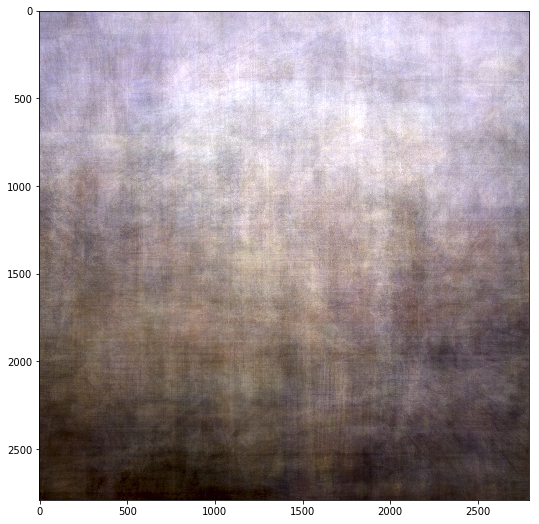

In [4]:
# pathlib ftw
img_path = Path('/home/jovyan/images/boulder_python/')
avg_img_path = img_path/'avg_march.jpg'

avg_img = io.imread(avg_img_path)
_ = plt.imshow(avg_img)

## python image manipulation libraries

* PIL (python imaging library)
  * quirky api, manipulations done with compiled code
  * can read images into a `numpy` array
* scikit-image
  * `numpy` "native"
  * pythonic api
  * some manipulations done in python
* openCV (C++ lib with python bindings)
  * `numpy` "native", but can run into undocumented data type (or `dtype`) issues
  * so fast
  * a beast to compile

## how to get these libraries

`pip` is good for PIL and scikit-image.

unless you're comfortable compiling libraries, use conda for openCV

if you're not familiar with conda:
* kinda like `pip` + `virtualenv` (or `pipenv`!) on steroids
* probably the best way to install `opencv` if you really need it
* can use pip to install packages into a conda environment

## start from the very basics: build an array

using numpy! and matplotlib!

let's make an image with a smiley face in it.

In [5]:
# make a smile mask

# rows are first index, columns are second
DEMO_IMAGE_SIZE = (7, 7)
SMILE_MASK = np.full(DEMO_IMAGE_SIZE, False, dtype=np.bool)
SMILE_MASK[1:3, 2] = True
SMILE_MASK[1:3, 4] = True
SMILE_MASK[5, 2:5] = True
SMILE_MASK[4, 1] = True
SMILE_MASK[4, 5] = True
SMILE_MASK

array([[False, False, False, False, False, False, False],
       [False, False,  True, False,  True, False, False],
       [False, False,  True, False,  True, False, False],
       [False, False, False, False, False, False, False],
       [False,  True, False, False, False,  True, False],
       [False, False,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False]])

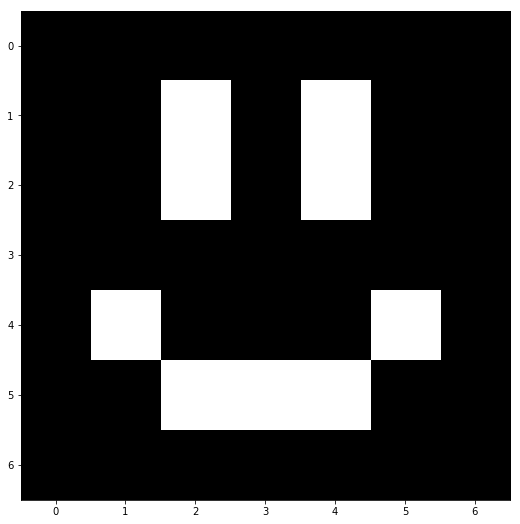

In [6]:
# make an int image array full of zeros
happy_face = np.zeros(DEMO_IMAGE_SIZE, dtype=np.uint8)

# set anywhere the SMILE_MASK is true to 1 and show it
happy_face[SMILE_MASK] = 1
_ = plt.imshow(happy_face, cmap='binary_r')

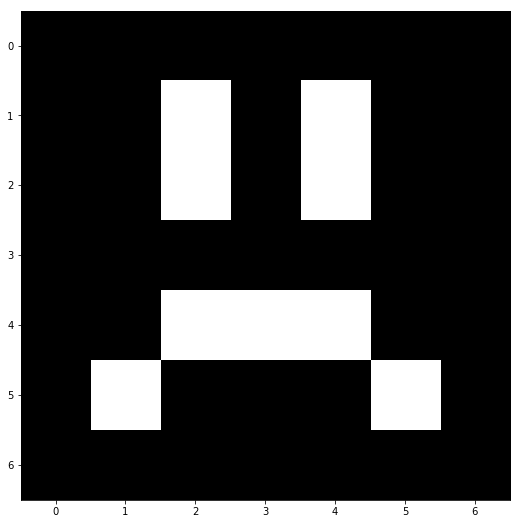

In [7]:
# make a sad face with twos in it
sad_face = np.zeros(DEMO_IMAGE_SIZE, dtype=np.uint8)
sad_face[FROWN_MASK] = 2
_ = plt.imshow(sad_face, cmap='binary_r')

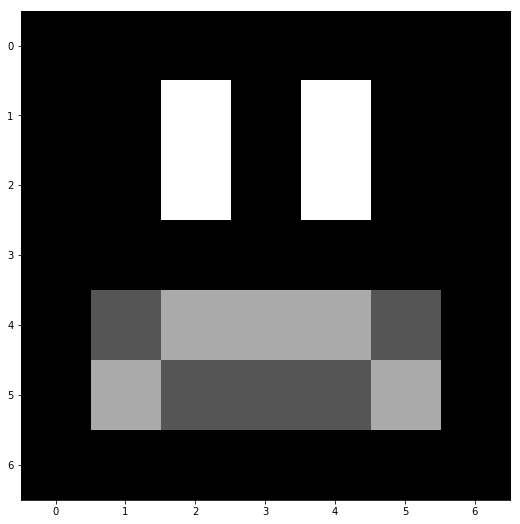

In [8]:
# now kiss
average_face = (happy_face + sad_face) / 2
_ = plt.imshow(average_face, cmap='binary_r')

## now let's try with real images

we'll use `scikit-image`'s `io` module to load the images and then use `numpy` from there.

In [9]:
# nice pathlib trick
# get all the files with the extension `.jpg` in the specified folder
input_img_path = img_path/'to_average'
input_image_filename_list = list(input_img_path.glob('*.jpg'))

# load the two files into memory
image_0 = io.imread(input_image_filename_list[0])
image_1 = io.imread(input_image_filename_list[1])

In [10]:
plt.rcParams["figure.figsize"] = (15,15)

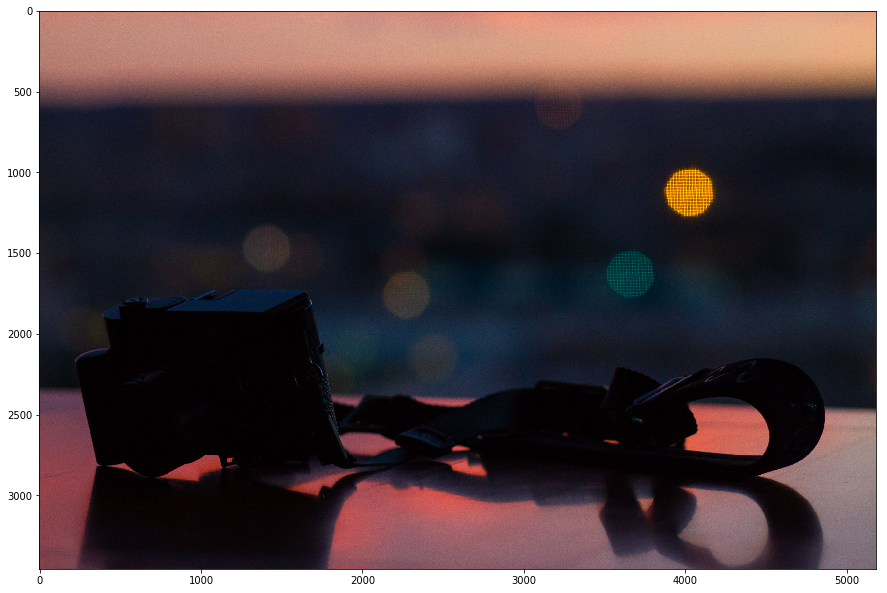

In [11]:
# show image 0
_ = plt.imshow(image_0)

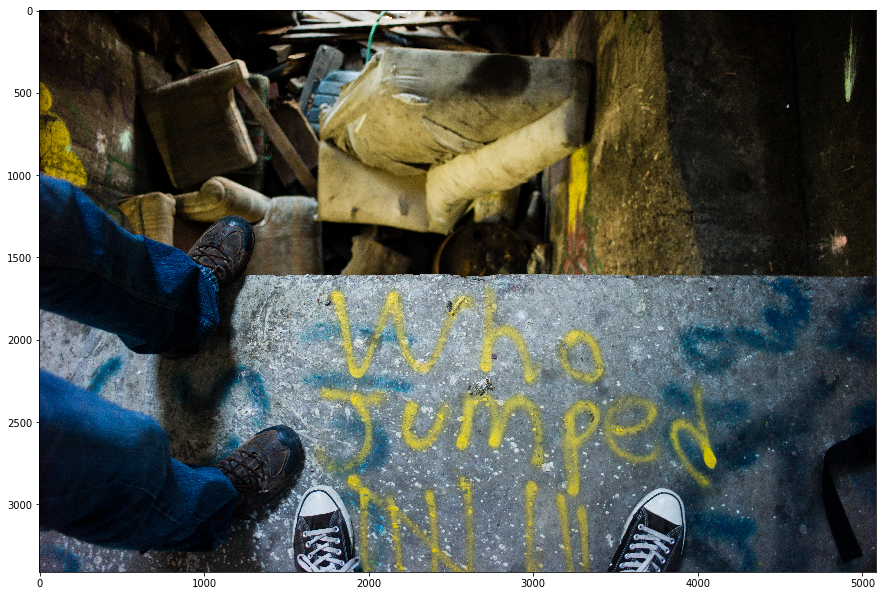

In [12]:
# show image 1
_ = plt.imshow(image_1)

In [13]:
# now kiss
average_photo = (image_0 + image_1) / 2
io.imshow(average_photo)

ValueError: operands could not be broadcast together with shapes (3456,5184,3) (3411,5086,3) 

## wha happen

let's look at the error.

```
ValueError: operands could not be broadcast together with shapes 
(3456,5184,3) (3411,5086,3) 
```

one image is larger than the other. addition on matrices that are different sizes is undefined.

## let's go through the motions of manually fixing this issue

why?
1. why not
2. because
3. debugging tools/IDEs aren't always useful for these kinds of issues
3. learning to explore bugs is a valuable skill

## goal

use the center of both images to make our average.

in the next figure, yellow line demonstrates size and shape of `image_1`, as well as the area of interest (AOI) within `image_0` we'd like to use

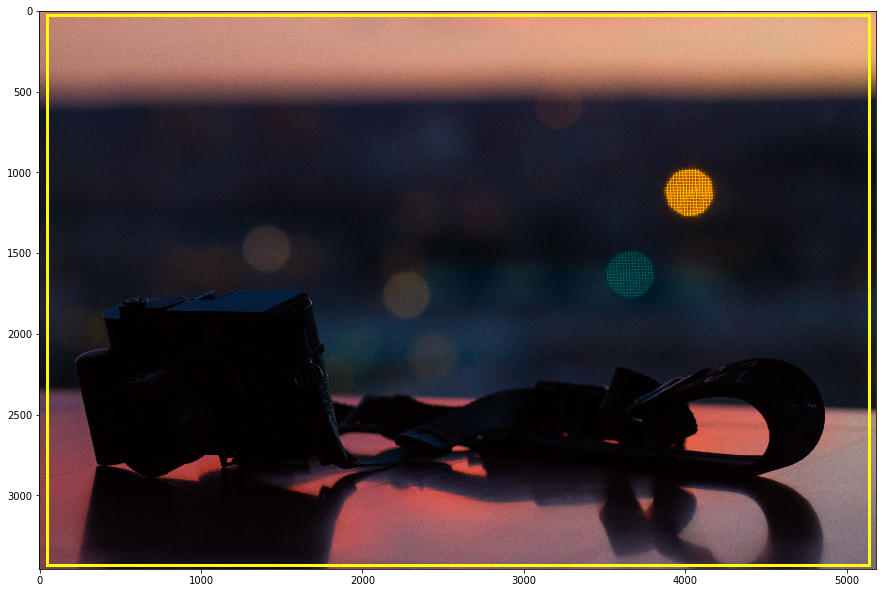

In [14]:
figure, axis = plt.subplots(1)
rect = patches.Rectangle((49, 23), 5086, 3410, linewidth=3, edgecolor='yellow',facecolor='none')
axis.add_patch(rect)
_ = axis.imshow(image_0)

In [15]:
# make sure the images have an even number of rows and columns

# trust me

def evenize_image(image):
    """Ensures an image has even dimensions."""
    (image_height, image_width, channels) = image.shape
    if (image_width % 2) == 1:
        # crop the width by 1
        image = image[0:image_height, 1:image_width]
    if (image_height % 2) == 1:
        # crop the height by 1
        image = image[1:image_height, 0:image_width]
    return image

print(f"before: image 0 size: {image_0.shape}, image 1 size: {image_1.shape}")

image_0 = evenize_image(image_0)
image_1 = evenize_image(image_1)

print(f"after: image 0 size: {image_0.shape}, image 1 size: {image_1.shape}")

before: image 0 size: (3456, 5184, 3), image 1 size: (3411, 5086, 3)
after: image 0 size: (3456, 5184, 3), image 1 size: (3410, 5086, 3)


In [16]:
# find the minimum dimensions
# rows
y_min_size = np.min([image_0.shape[0], image_1.shape[0]])
# columns
x_min_size = np.min([image_0.shape[1], image_1.shape[1]])

crop_dimension = (y_min_size, x_min_size)
crop_dimension

(3410, 5086)

In [17]:
# center crop both images to the minimum size—define a function

def crop_image_to_dimensions(image, dimensions):
    """Crops an image to a specified dimension."""
    (image_height, image_width, channels) = image.shape
    w_crop_amount = (image_width - dimensions[1]) // 2
    h_crop_amount = (image_height - dimensions[0]) // 2
    image = image[
        h_crop_amount:image_height - h_crop_amount,
        w_crop_amount:image_width - w_crop_amount]
    return image

print(f"before: image 0 size: {image_0.shape}, image 1 size: {image_1.shape}")

image_0 = crop_image_to_dimensions(image_0, crop_dimension)
image_1 = crop_image_to_dimensions(image_1, crop_dimension)

print(f"after: image 0 size: {image_0.shape}, image 1 size: {image_1.shape}")

before: image 0 size: (3456, 5184, 3), image 1 size: (3410, 5086, 3)
after: image 0 size: (3410, 5086, 3), image 1 size: (3410, 5086, 3)


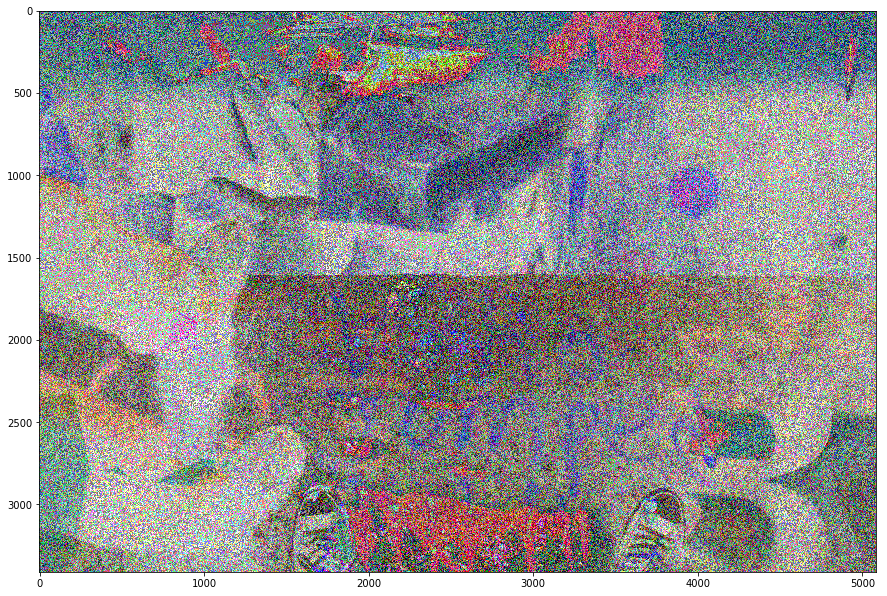

In [18]:
# now kiss
average_photo = (image_0 + image_1) / 2
_ = plt.imshow(average_photo)

## no errors! but it looks weird.

things to think about when debugging:

1. `dtypes`
2. value ranges in the input and output images
3. histograms are your friend
3. `plt.imshow` will try to stretch contrast if necessary

In [19]:
# what's the dtype?
print(f"average_photo dtype: {average_photo.dtype}")

# ah ha. so `plt.imshow` was doing weird stuff for display purposes.

average_photo dtype: float64


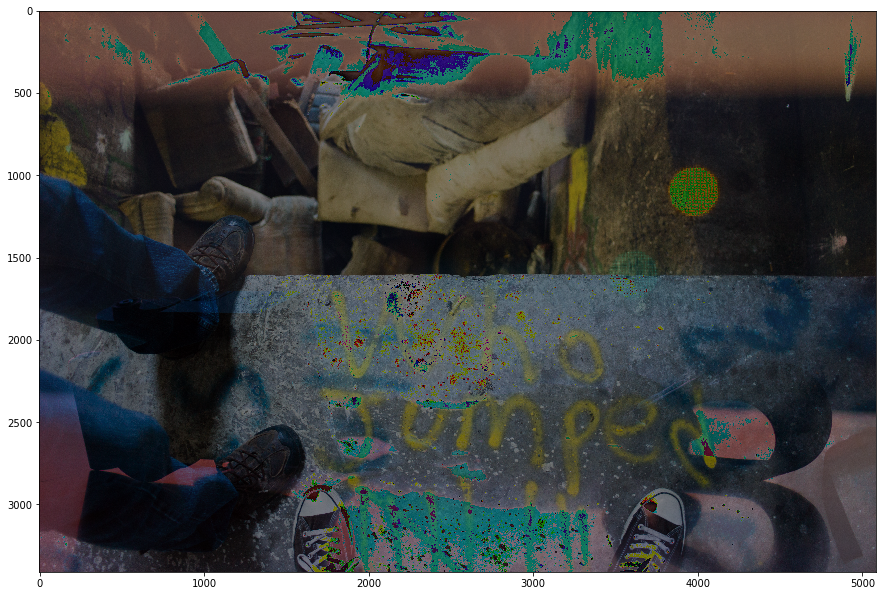

In [20]:
# try plotting as `uint8` so `plt.imshow` doesn't do any dirty tricks
_ = plt.imshow(average_photo.astype(np.uint8))

# huh, the areas that should be bright are exhibiting some weird artifacts

In [21]:
# still have some weird issues, let's look at the value ranges

# how do y'all feel about executing code in f strings
print(f"""image_0 value range: {(np.min(image_0), np.max(image_0))}
image_1 value range: {(np.min(image_1), np.max(image_1))}
average_photo value range: {(np.min(average_photo), np.max(average_photo))}""")

# huh, seems like we should have some values > 127.5

image_0 value range: (0, 255)
image_1 value range: (0, 255)
average_photo value range: (0.0, 127.5)


In [22]:
plt.rcParams["figure.figsize"] = (9,9)

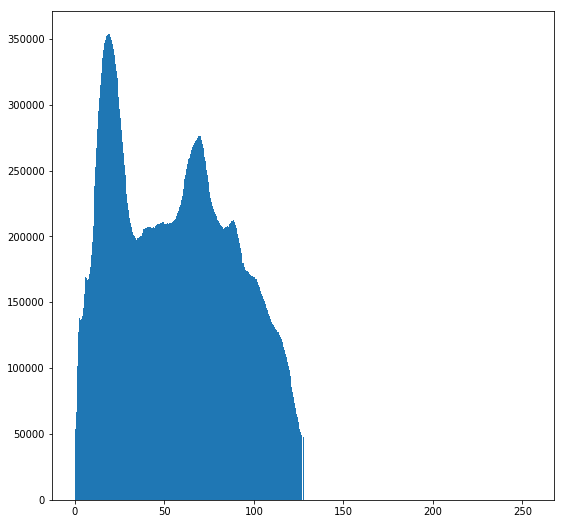

In [23]:
# this is a good looking histogram except for the abrupt cutoff

_ = plt.hist(average_photo.ravel(), bins=512, range=(0, 255))

## what's going on here?

take a look at the code:

```python3
average_photo = (image_0 + image_1) / 2
```

anybody see any issues?

let's do a little exploration to figure out what's going on

In [24]:
# make a vector
test_vec_1 = np.zeros((5), dtype=np.uint8)

# populate it a little
test_vec_1[[1, 3]] = 128

# make a vector full of the value 224
test_vec_2 = 224 * np.ones((5), dtype=np.uint8)
# or use `np.full` if you're not a matlab heathen

# now kiss
test_vec_1 + test_vec_2

array([224,  96, 224,  96, 224], dtype=uint8)

# overflow!

$$
\begin{align}
128 + 224&=352\\
352 - 256&=96\\
\text{or}\\
352 \bmod 256 &= 96
\end{align}$$

order of operations is important in these cases because it turns out $[0, 255]$ is a small subset of all numbers and therefore arithmetic functions differently than one might expect.

instead of this formulation:

$$AM={1\over{N}}\sum_{i=1}^{N}a_i$$

let's use this one:

$$AM={\sum_{i=1}^{N} {a_i\over{N}}}$$

In [25]:
plt.rcParams["figure.figsize"] = (15,15)

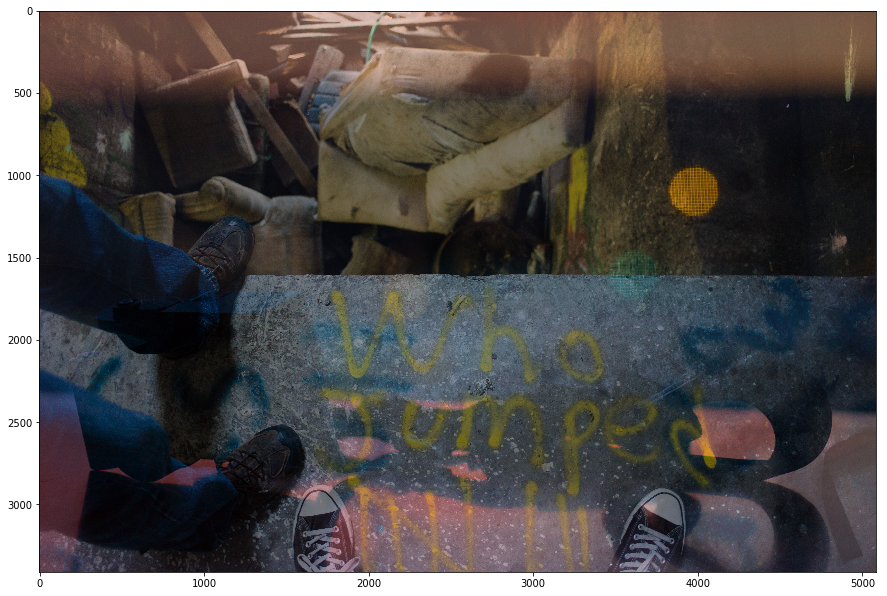

In [26]:
# divide then kiss
average_photo_rad = image_0 / 2 + image_1 / 2
_ = plt.imshow(average_photo_rad.astype(np.uint8))

# much better!

just to follow up, let's look at the histogram and value ranges.

In [27]:
# let's look at the value ranges

print(f"average_photo_rad value range: {(np.min(average_photo_rad), np.max(average_photo_rad))}")

# hmm, doesn't go all the way up to 255

average_photo_rad value range: (0.0, 239.0)


In [28]:
plt.rcParams["figure.figsize"] = (9,9)

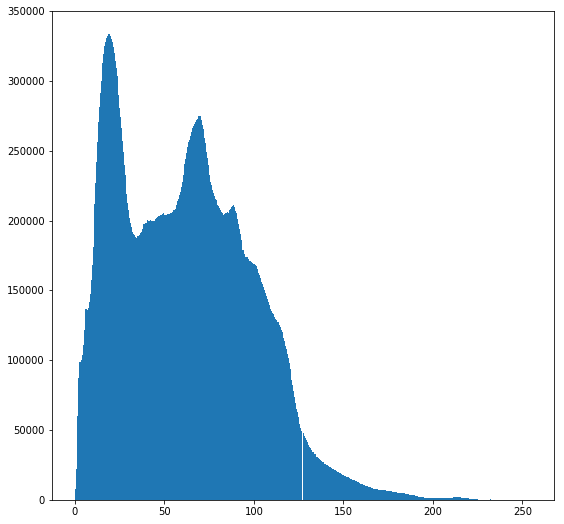

In [29]:
# better! but most of the data still only occupies half of the value range

_ = plt.hist(average_photo_rad.ravel(), bins=512, range=(0, 255))

## we can fix that if we wanna

the process just described isn't really correct for a few reasons (averaging in sRGB colorspace instead of linear RGB for example), but, you know, artistic license.

i wanna make it a little brighter so i'm gonna.

we'll find the range that 99% of the data is contained within, and then perform "contrast stretching" to brighten it up a little.

In [30]:
plt.rcParams["figure.figsize"] = (15,15)

In [31]:
# use np.percentile to find a percentile range
low_val, high_val = np.percentile(average_photo_rad, (0, 99))

print(f"99% of the data lies within the range {(low_val, high_val)}")

99% of the data lies within the range (0.0, 159.0)


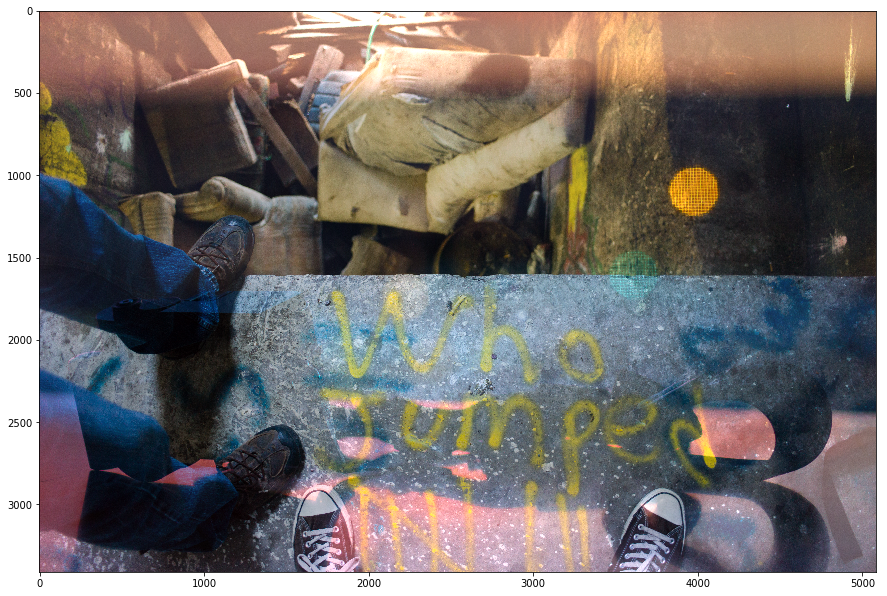

In [32]:
avg_photo_rad_rescale = exposure.rescale_intensity(np.copy(average_photo_rad),
                                                   in_range=(low_val, high_val),
                                                   out_range=np.uint8)
_ = plt.imshow(avg_photo_rad_rescale.astype(np.uint8))

In [33]:
plt.rcParams["figure.figsize"] = (9,9)

avg_photo_rad_rescale value range: (0.0, 255.0)


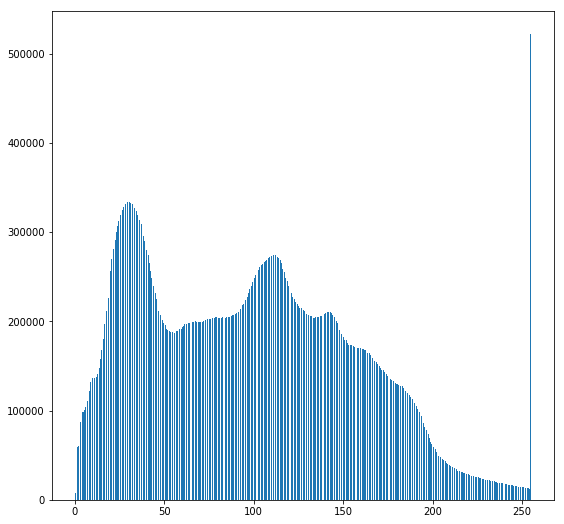

In [34]:
_ = plt.hist(avg_photo_rad_rescale.ravel(), bins=512, range=(0, 255))
print(f"avg_photo_rad_rescale value range: {(np.min(avg_photo_rad_rescale), np.max(avg_photo_rad_rescale))}")

# whoa

lots of values in the 255 bin! that means we are clipping some data. but, that's expected given how we chose to rescale the image.

## okay bye

presentation available at:

slides:
### [thisisreal.net/talks/20181009_boulder_python/](https://thisisreal.net/talks/20181009_boulder_python/)
notebook:
### [https://github.com/whlteXbread/talk_notebooks/](https://github.com/whlteXbread/talk_notebooks/blob/master/20181009_boulder_python_avg_day.ipynb)

thisisreal.net

@whltexbread

@whltexbread@xoxo.zone

github.com/whltexbread